# Homework 01: Binary Classification with Neural Networks

## Due: Sunday September 7 @ 11:59 (with 2-hour grace period) and worth 85 points

In this assignment, you'll build your first deep learning models using **Keras**, a high-level deep learning framework built on TensorFlow.

We’ll solve a binary classification task, using the Wisconsin Breast Cancer dataset. 

You’ll start by training a simple baseline model, and then explore a series of alternate network designs.  For each model, you’ll:

- Track training loss and accuracy over epochs
- Report final test set performance (loss and accuracy)

The goal is to begin developing an intuition for how network design choices influence performance—and to get comfortable with the end-to-end modeling workflow in Keras.


There are 12 graded problems, each worth 7 points, and you get 1 point free. 


In [1]:
# Useful Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential

random_seed = 42

In [2]:
# Utility function: Plotting Training Loss (x-entropy) and Accuracy
# We'll replace this with a different function train_and_test when we develop more
# training techniques.

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')


## Prelude: Load and Explore the Wisconsin Breast Cancer Dataset

You should **always** perform EDA when working with a new dataset. We've seen this one before, but its always worth becoming familiar with the data before building a model!

In [3]:
# Load dataset with as DataFrame for EDA
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True)

df = data.frame  # Convenient alias for combined data+target

In [4]:
# Uncomment and look at this

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

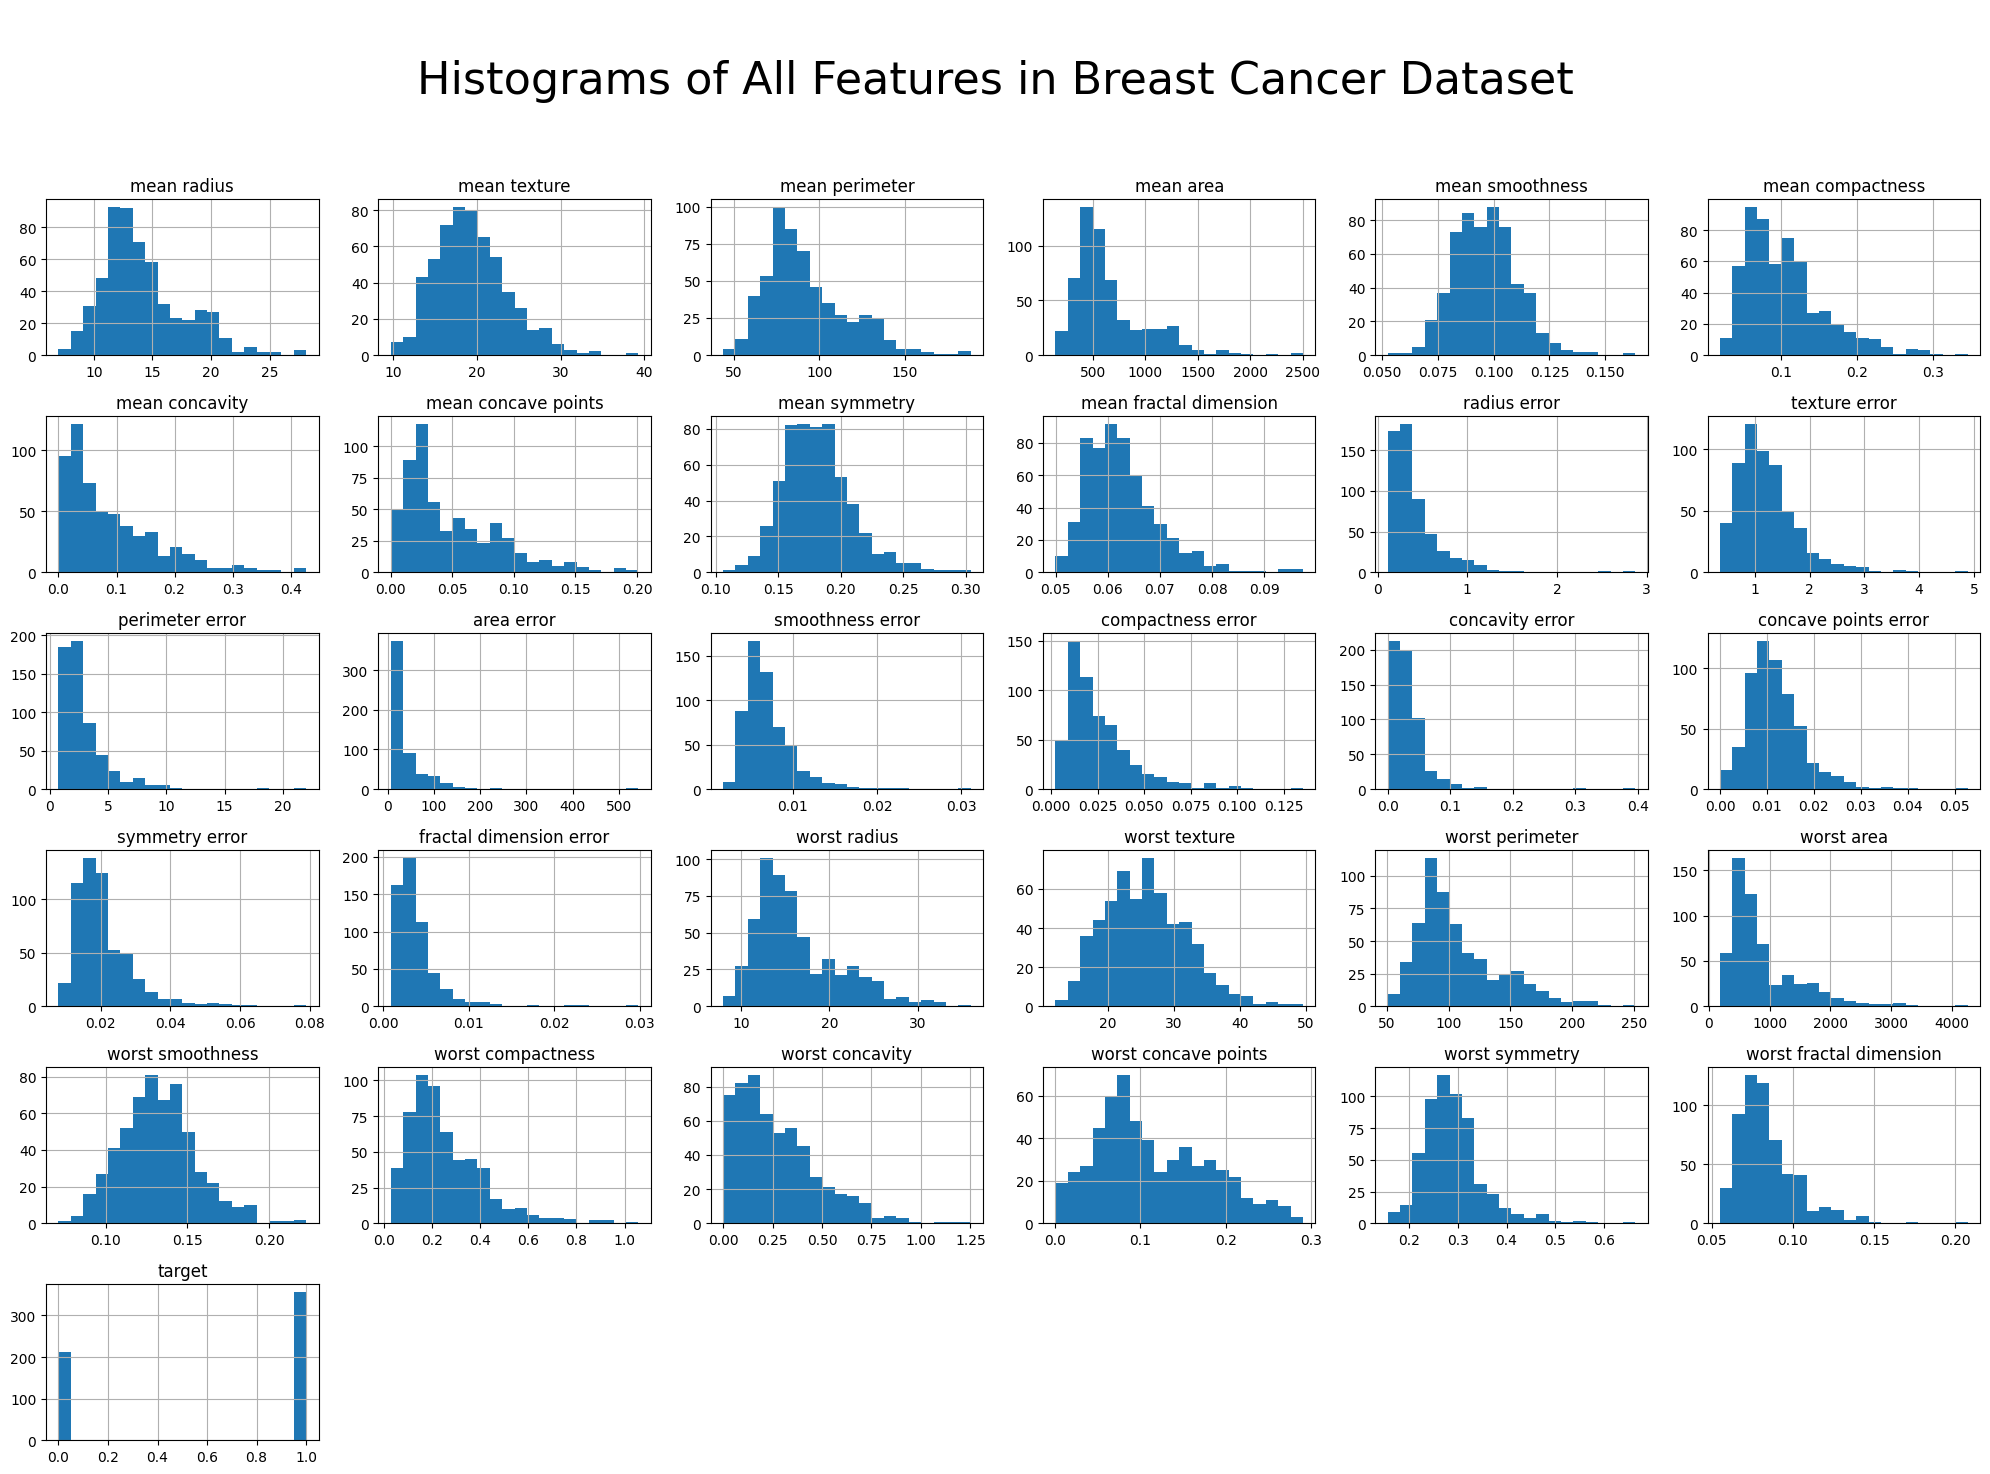

In [5]:
# Uncomment and look at this

fig = df.hist(bins=20, figsize=(20, 15), layout=(6, 6))
plt.suptitle("\nHistograms of All Features in Breast Cancer Dataset", fontsize=32)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
plt.show()

## Problem One: Dealing with unbalanced target variables and establishing a baseline model

### Part A: Compute the imbalance of the target

Neural networks work best with standardized datasets; for classification tasks, it is also important
to account for an unbalanced target. Let's create our `X,y` data structure and look at the target more closely. 

1. **Convert the data to NumPy arrays:** Extract the feature matrix `X` and the target vector `y` from the DataFrame, and
convert them to NumPy arrays. Print the shapes of `X` and `y` to confirm the conversion was successful.  

2. **Check for class imbalance:**
   Use `Counter` (or another appropriate method) to print the frequency of each class label in the target array `y`. This will help you understand how balanced (or imbalanced) the classes are.

3. **Compute the proportion of class 1:**
   Calculate what percentage of the samples belong to class label `1` and provide your answer in the graded question. 



In [6]:
# A.1

# Features and target
X = df.drop(columns="target").to_numpy()
y = df["target"].to_numpy()

# Confirm shapes
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (569, 30)
y shape: (569,)


In [7]:
# A.2

class_counts = Counter(y)
print("Class counts:", class_counts)

Class counts: Counter({np.int64(1): 357, np.int64(0): 212})


In [8]:
# A.3

# Set a1a to the percentage (a float between 0 and 1) of 1's in the target
# Use an expression, not constants derived from inspecting the data

a1a = class_counts[1] / len(y)            # Replace 0.0 with your answer

In [9]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')                     

a1a = 0.6274


### Part B: Perform a stratified test/train split

In classification problems with imbalanced datasets, it's important to address the class imbalance so that the model doesn't become biased toward the majority class. There are two common strategies:

* **Resampling** the dataset to balance the classes (by oversampling the minority class or undersampling the majority class).
* **Adjusting the loss function** so that errors on minority classes have more influence during training.

In this problem, you'll explore the second approach—using class weights to influence how the model learns.

This strategy involves two key steps:

1. **Preserve class proportions in the train/test split**
   Use the  parameter `stratify=y`in `train_test_split` to ensure that both the training and testing sets maintain the same class distribution as in the original target.

2. **Apply class weighting during training**
   Use the `class_weight` parameter in the `fit` function to assign different weights to each class when computing the loss. This helps ensure that the model pays appropriate attention to both common and rare classes.


**We'll do the first step now, perform standardization, and then do the second step in Part C.** 

In [10]:
# Perform train-test split, keeping both stratified, use random_state = random_seed and test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Class distribution in train:", Counter(y_train))
print("Class distribution in test:", Counter(y_test))

Train set shape: (455, 30) (455,)
Test set shape: (114, 30) (114,)
Class distribution in train: Counter({np.int64(1): 285, np.int64(0): 170})
Class distribution in test: Counter({np.int64(1): 72, np.int64(0): 42})


**(Digression:** We must perform standardization **after** the test/train split, or else we're letting
information about the mean and standard deviation of the test set influence training--a classic case of *data leakage*.
**)**

In [11]:
# As usual, standardize the features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Let's see if the stratification worked! Assign `a1b` to the percentage of 1's in `y_train` (and convince yourself that if it is approximately correct, then so must be `y_test`). 

In [12]:
# Set a1b to the percentage (a float between 0 and 1) of 1's in the target
# Use an expression, not constants derived from inspecting the data

a1b = np.mean(y_train)             # Replace 0.0 with your answer

In [13]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}')  

a1b = 0.6264


## Part C: Train a baseline model with class weighting

Now we'll build a baseline model with class weighting during training. 

To compute the weight for class $i$, use the following formula:

$$
\text{weight}_i = \frac{n}{k \cdot n_i},
$$

where:

* $n$ is the total number of samples,
* $n_i$ is the number of samples in class $i$,
* $k$ is the total number of classes.

This formula scales the loss so that each class contributes approximately equally during training—without changing the number of training samples.

To apply class weighting during training, we use the parameter `class_weight=weights` in the `fit` function, where `weights` is a dictionary 

    { 0 : weight_0, 1 : weight_1 }

as specified in the formula above. 

**Note**: As an alternative, you can also use `sklearn.utils.class_weight` to do the calculation. 

**TODO: Complete the template to**

-  Build a network consisting of a single logistic regression classifier (done for you!)
-  Compile it using the same parameters as shown in the coding video, except we will use the `Adam` optimizer:
>          optimizer='adam'
-  Train it for **100** epochs, calculating the class weights explicitly as shown or using `sklearn.utils.class_weight` (look up the docs!)
-  Display the training loss and accuracy curves using `plot_history`
-  Complete the graded question 

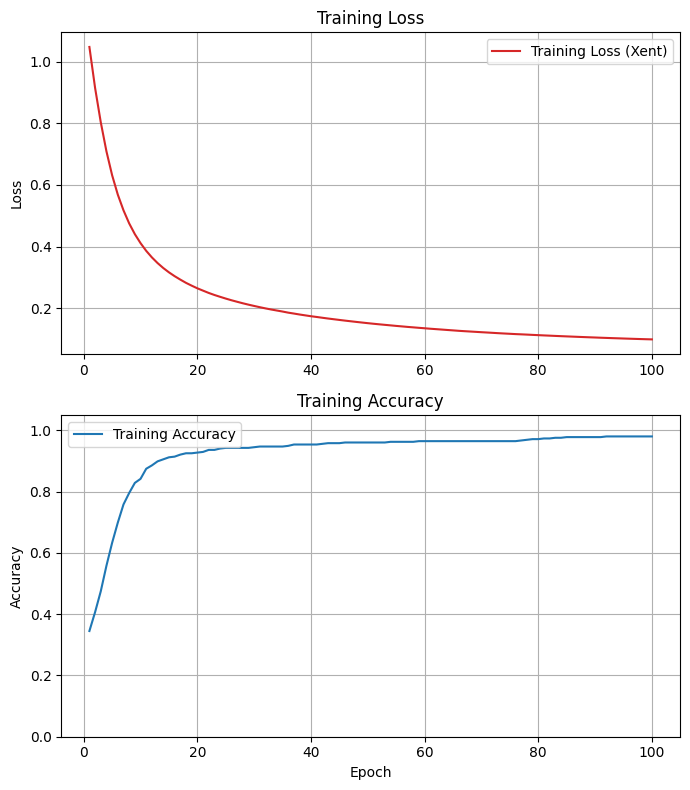

Final Training Loss:     0.0987
Final Training Accuracy: 0.9802


In [14]:
# Try a baseline model consisting of a single logistic regression classifier.
# This is very similar to sklearn's LogisticRegression model. 

n_epochs = 100
weights_sklearn = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = {i: weights_sklearn[i] for i in range(len(weights_sklearn))}
# We use Sequential to build a simple classification network from
# a list of layers, and print the summary

# Uncomment this when you have defined X_train:


model_baseline = keras.Sequential(
    [
       keras.layers.Input(shape=(X_train.shape[1],)),     # Explicit input layer
       keras.layers.Dense(1, activation="sigmoid")
    ]
)

model_baseline.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model_baseline.fit(
    X_train_scaled, y_train,
    epochs=100,
    class_weight=weights_dict,
    verbose=0   
)

plot_history(history)

In [15]:
# Set a1c to the final training accuracy (at epoch 100)
# You MUST use an expression here, not a constant from inspecting the results

a1c = history.history['accuracy'][-1]             # Replace 0.0 with your answer

In [16]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1c = {a1c:.4f}')  

a1c = 0.9802


### Part D: Testing

- Calculate the testing loss and accuracy and answer the graded question.
- Print out both with appropriate labels
- Answer the graded question

In [17]:
# Your code here

test_loss, test_acc = model_baseline.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9649 - loss: 0.1231 
Test Loss:     0.1231
Test Accuracy: 0.9649


In [18]:
# Set a1d to the final testing accuracy
# Use the appropriate variable; do not insert a constant from inspection of the results

a1d = test_acc             # Replace 0.0 with your answer

In [19]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1d = {a1d:.4f}') 

a1d = 0.9649


## Problem Two: Explore alternate network designs

For the remaining problems, you will experiment with several different network designs.

For Problem Two, redo the work you did in Parts C and D of Problem One, but with a network with a single hidden layer of 16 neurons, using the sigmoid activation function, which
will have the following summary chart (the layer name may be different than shown here):

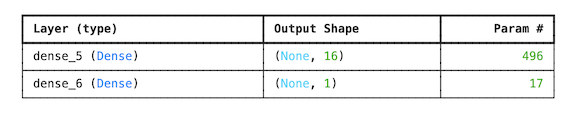


Then answer the graded questions.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513 (2.00 KB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

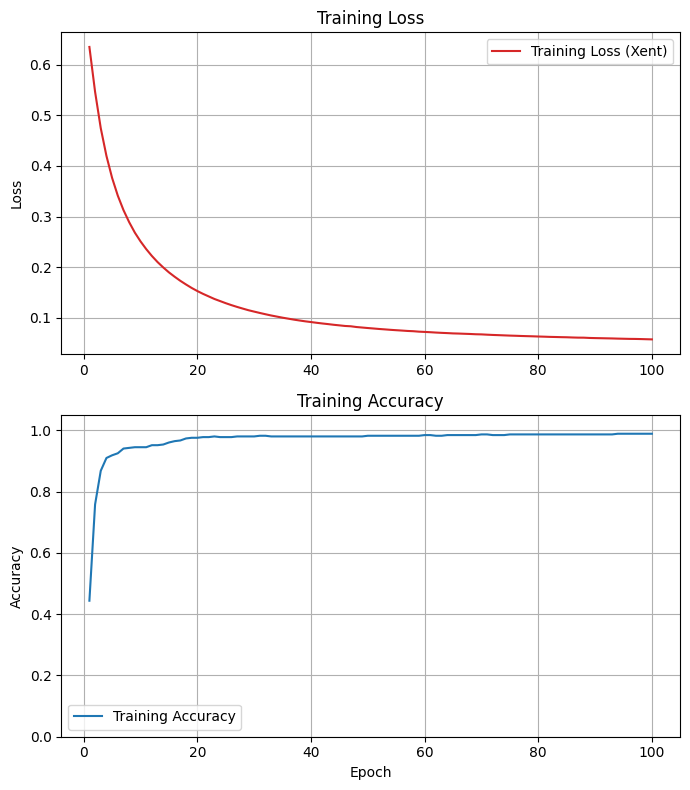

Final Training Loss:     0.0569
Final Training Accuracy: 0.9890
[Hidden=16 sigmoid] Test Loss: 0.0955
[Hidden=16 sigmoid] Test Accuracy: 0.9474


In [20]:
# Your code here, add additional cells if you wish

n_epochs = 100
weights_sklearn = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = {i: weights_sklearn[i] for i in range(len(weights_sklearn))}
# We use Sequential to build a simple classification network from
# a list of layers, and print the summary

# Uncomment this when you have defined X_train:

model_16 = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(16, activation="sigmoid"),
    keras.layers.Dense(1, activation="sigmoid")
])

model_16.compile(optimizer="adam",
                 loss="binary_crossentropy",
                 metrics=["accuracy"])

model_16.summary()

history_16 = model_16.fit(
    X_train_scaled, y_train,
    epochs=100,
    class_weight=weights_dict,
    verbose=0
)

plot_history(history_16)

test_loss_16, test_acc_16 = model_16.evaluate(X_test_scaled, y_test, verbose=0)
print(f"[Hidden=16 sigmoid] Test Loss: {test_loss_16:.4f}")
print(f"[Hidden=16 sigmoid] Test Accuracy: {test_acc_16:.4f}")

In [21]:
# Set a2a to the final training accuracy
# Use the appropriate variable or expression; do not insert a constant from inspection of the results

a2a =   history_16.history['accuracy'][-1]           # Replace 0.0 with your answer

In [22]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.4f}') 

a2a = 0.9890


In [23]:
# Set a2b to the final testing accuracy
# Use the appropriate variable; do not insert a constant from inspection of the results

a2b = test_acc_16             # Replace 0.0 with your answer

In [24]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.9474


## Problem Three: Explore alternate network designs


For Problem Three, redo the work you did in Parts C and D of Problem One, but with a network with a  hidden layer of 64 neurons, 
using the sigmoid activation function, which
will have the following summary chart:

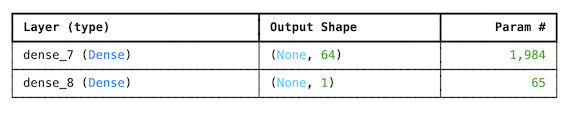


Then answer the graded questions.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

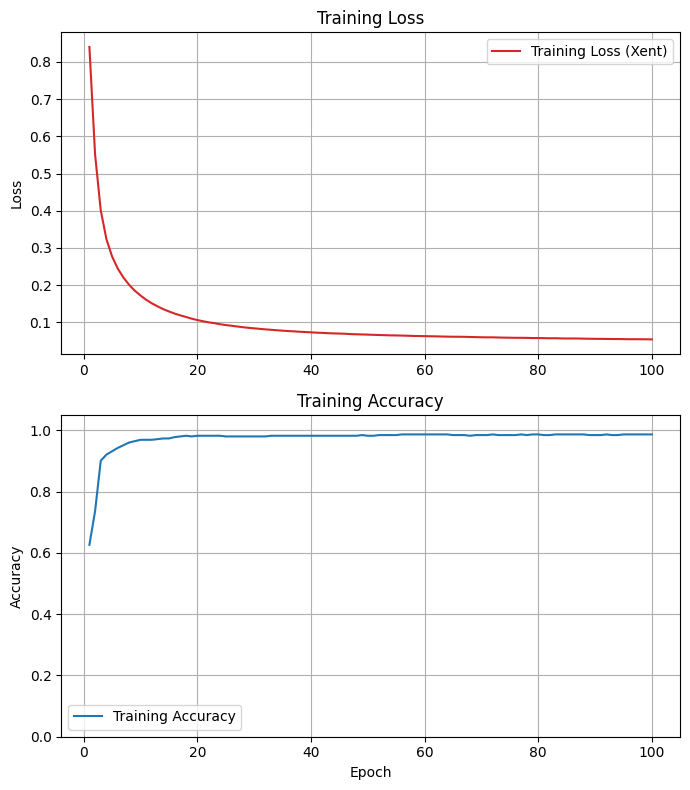

Final Training Loss:     0.0541
Final Training Accuracy: 0.9868
[Hidden=64 sigmoid] Test Loss: 0.0884
[Hidden=64 sigmoid] Test Accuracy: 0.9474


In [25]:
# Your code here, add additional cells if you wish

n_epochs = 100
weights_sklearn = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = {i: weights_sklearn[i] for i in range(len(weights_sklearn))}
# We use Sequential to build a simple classification network from
# a list of layers, and print the summary

# Uncomment this when you have defined X_train:

model_64 = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation="sigmoid"),
    keras.layers.Dense(1, activation="sigmoid")
])

model_64.compile(optimizer="adam",
                 loss="binary_crossentropy",
                 metrics=["accuracy"])

model_64.summary()

history_64 = model_64.fit(
    X_train_scaled, y_train,
    epochs=100,
    class_weight=weights_dict,
    verbose=0
)

plot_history(history_64)

test_loss_64, test_acc_64 = model_64.evaluate(X_test_scaled, y_test, verbose=0)
print(f"[Hidden=64 sigmoid] Test Loss: {test_loss_64:.4f}")
print(f"[Hidden=64 sigmoid] Test Accuracy: {test_acc_64:.4f}")

In [26]:
# Set a3a to the final training accuracy
# Use the appropriate variable or expression; do not insert a constant from inspection of the results

a3a = history_64.history['accuracy'][-1]             # Replace 0.0 with your answer

In [27]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.9868


In [28]:
# Set a3b to the final testing accuracy
# Use the appropriate variable; do not insert a constant from inspection of the results

a3b = test_acc_64            # Replace 0.0 with your answer

In [29]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.9474


## Problem Four: Explore alternate network designs


For Problem Four, redo the work you did in Parts C and D of Problem One, but with a network with  a hidden layer of 256 neurons, using the sigmoid activation function, which
will have the following summary chart:

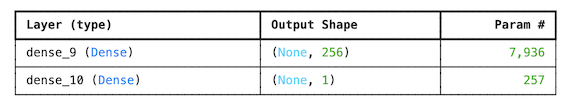


Then answer the graded questions.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,193 (32.00 KB)

 Trainable params: 8,193 (32.00 KB)

 Non-trainable params: 0 (0.00 B)

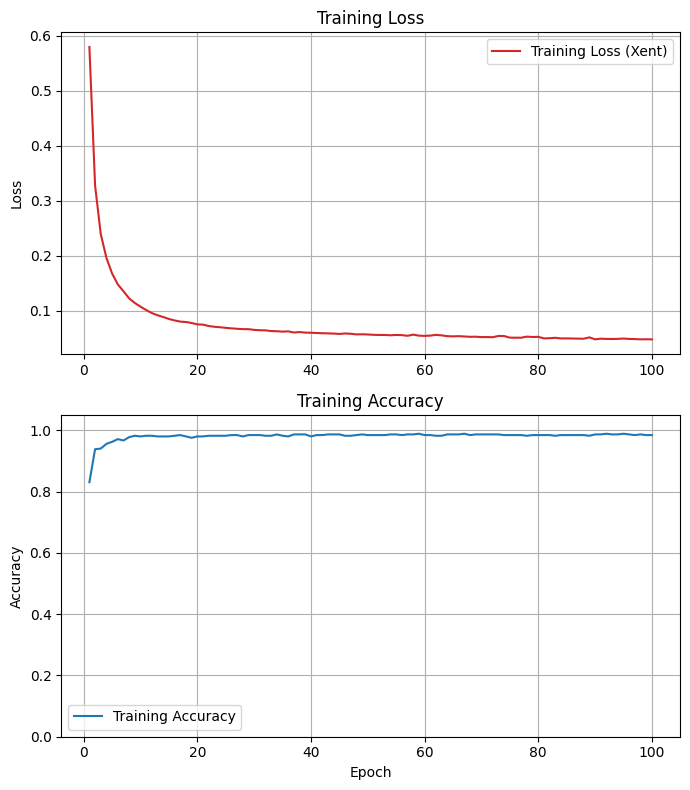

Final Training Loss:     0.0483
Final Training Accuracy: 0.9846
[Hidden=256 sigmoid] Test Loss: 0.0897
[Hidden=256 sigmoid] Test Accuracy: 0.9474


In [30]:
# Your code here, add additional cells if you wish

n_epochs = 100
weights_sklearn = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = {i: weights_sklearn[i] for i in range(len(weights_sklearn))}
# We use Sequential to build a simple classification network from
# a list of layers, and print the summary

# Uncomment this when you have defined X_train:

model_256 = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(256, activation="sigmoid"),
    keras.layers.Dense(1, activation="sigmoid")
])

model_256.compile(optimizer="adam",
                 loss="binary_crossentropy",
                 metrics=["accuracy"])

model_256.summary()

history_256 = model_256.fit(
    X_train_scaled, y_train,
    epochs=100,
    class_weight=weights_dict,
    verbose=0
)

plot_history(history_256)

test_loss_256, test_acc_256 = model_256.evaluate(X_test_scaled, y_test, verbose=0)
print(f"[Hidden=256 sigmoid] Test Loss: {test_loss_256:.4f}")
print(f"[Hidden=256 sigmoid] Test Accuracy: {test_acc_256:.4f}")

In [31]:
# Set a4a to the final training accuracy
# Use the appropriate variable or expression; do not insert a constant from inspection of the results

a4a = history_256.history['accuracy'][-1]             # Replace 0.0 with your answer

In [32]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.9846


In [33]:
# Set a4b to the final testing accuracy
# Use the appropriate variable; do not insert a constant from inspection of the results

a4b = test_acc_256             # Replace 0.0 with your answer

In [34]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.9474


## Problem Five: Explore alternate network designs


For Problem Five, redo the work you did in Parts C and D of Problem One, but with a network with two hidden layers of 64  and 32 neurons, using the sigmoid activation function for all layers, which
will have the following summary chart:

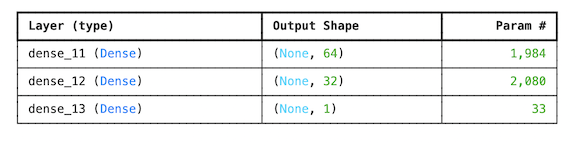

Then answer the graded questions.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

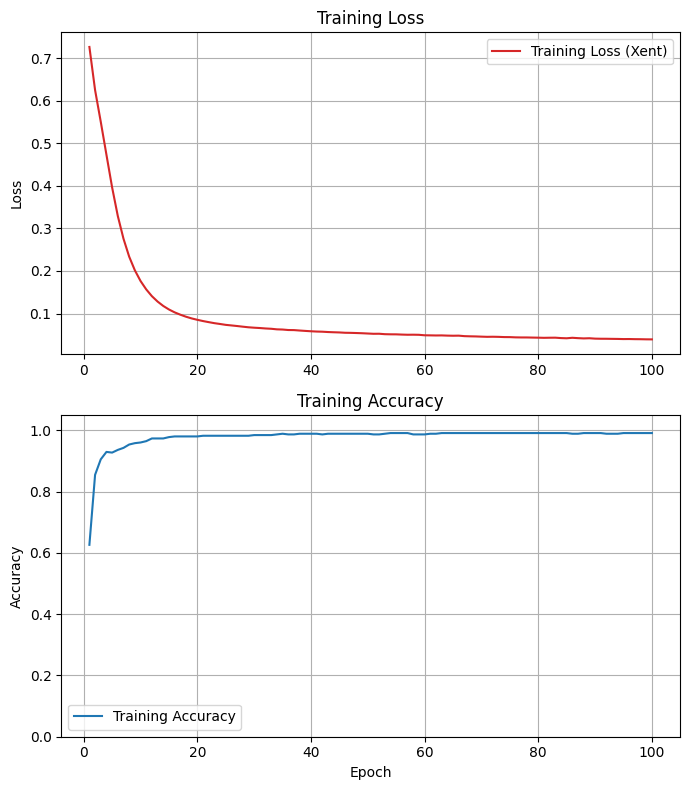

Final Training Loss:     0.0393
Final Training Accuracy: 0.9912
[Multi sigmoid] Test Loss: 0.1180
[Multi sigmoid] Test Accuracy: 0.9474


In [35]:
# Your code here, add additional cells if you wish

n_epochs = 100
weights_sklearn = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = {i: weights_sklearn[i] for i in range(len(weights_sklearn))}
# We use Sequential to build a simple classification network from
# a list of layers, and print the summary

# Uncomment this when you have defined X_train:

model_multi = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation="sigmoid"),
    keras.layers.Dense(32, activation="sigmoid"),
    keras.layers.Dense(1, activation="sigmoid")
])

model_multi.compile(optimizer="adam",
                 loss="binary_crossentropy",
                 metrics=["accuracy"])

model_multi.summary()

history_multi = model_multi.fit(
    X_train_scaled, y_train,
    epochs=100,
    class_weight=weights_dict,
    verbose=0
)

plot_history(history_multi)

test_loss_multi, test_acc_multi = model_multi.evaluate(X_test_scaled, y_test, verbose=0)
print(f"[Multi sigmoid] Test Loss: {test_loss_multi:.4f}")
print(f"[Multi sigmoid] Test Accuracy: {test_acc_multi:.4f}")

In [36]:
# Set a5a to the final training accuracy
# Use the appropriate variable or expression; do not insert a constant from inspection of the results

a5a = history_multi.history['accuracy'][-1]            # Replace 0.0 with your answer

In [37]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.9912


In [38]:
# Set a5b to the final testing accuracy
# Use the appropriate variable; do not insert a constant from inspection of the results

a5b = test_acc_multi             # Replace 0.0 with your answer

In [39]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.9474


## Reflection Questions:

You won't be graded on these, and you don't need to write anything, but here are some things to think about after completing the experiments. 

1. After the baseline, we tried wider and wider models, and then a deeper model. Which idea worked better in terms of training accuracy (at least for this data split)? What model would you try next to test this hypothesis?

2. What effect did these experiments have on the testing accuracy?  Can you suggest an explanation for this? Rather than me giving you ideas, have a conversation with `ChatGPT` in which you describe your experiments, and the dataset, and explore with it why the testing results turned out this way.

3. What do you think would happen if you tried running the same experiments with a different random seed (and hence a different split in a fairly small dataset)?  